In [31]:
import gym
import minerl
import matplotlib.pyplot as plt

import gc
import numpy as np
from tqdm import tqdm
from timeit import default_timer as timer
from collections import OrderedDict

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

In [2]:
data = minerl.data.make("MineRLTreechop-v0")

In [3]:
noise_dim = 16

trajectory_names = data.get_trajectory_names()
trajectories = [[x for x in data.load_data(k)] for k in trajectory_names[:-32]]
trajectory_lens = [len(t) for t in trajectories]
noise_arr = [np.random.randn(l, noise_dim) for l in trajectory_lens]

trajectories_eval = [[x for x in data.load_data(k)] for k in trajectory_names[-32: ]]
trajectory_lens_eval = [len(t) for t in trajectories_eval]
noise_arr_eval = [np.random.randn(l, noise_dim) for l in trajectory_lens_eval]


100%|██████████████████████████████████████████████████████████████████████████| 1784/1784 [00:00<00:00, 162144.37it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2931/2931 [00:00<00:00, 127407.04it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2729/2729 [00:00<00:00, 151577.93it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2231/2231 [00:00<00:00, 159330.70it/s]


In [4]:
i = 0

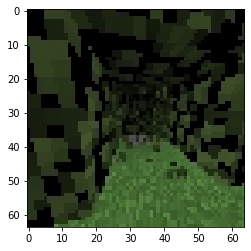

In [5]:
i += 1
plt.imshow(trajectories[0][i][0]['pov'])

In [6]:
#generate a query from state vector
#query the gnn to obtain the next macro action
#combine state and macro action into conditional distribution of micro actions

#challenges:
#gnn should compress the gameplan (set of macro actions for solving env)

In [7]:
len(trajectory_names)

209

In [8]:
batch_size = 32
seq_len = 256
noise_dim = 16


In [9]:
test_rew = [x[2] for x in trajectories[0]]

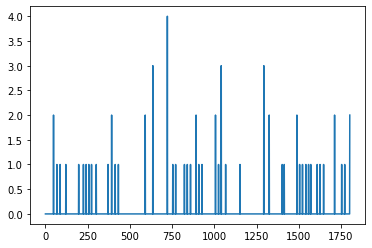

In [10]:
plt.plot(test_rew)

In [11]:
def discounted_reward(rewards):
    gamma = 0.99
    ret = []
    cumulative_reward = 0.
    for r in reversed(rewards):
        cumulative_reward = r + gamma * cumulative_reward
        ret.insert(0, cumulative_reward)
        
    return ret

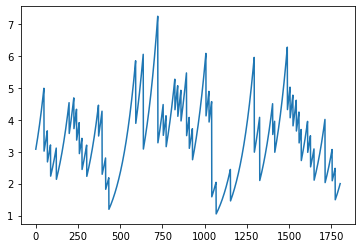

In [12]:
plt.plot(discounted_reward(test_rew))

In [13]:
discounted_rewards = [discounted_reward([x[2] for x in trajectories[i]]) for i in range(len(trajectories))]
discounted_rewards_eval = [discounted_reward([x[2] for x in trajectories_eval[i]]) for i in range(len(trajectories_eval))]

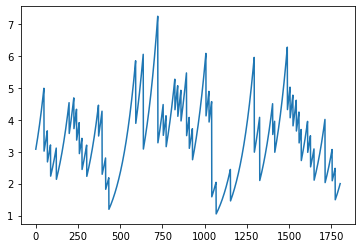

In [14]:
plt.plot(discounted_rewards[0])

In [15]:
n_sequences_per_trajectory = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens)}
n_sequences_per_trajectory_eval = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens_eval)}
# remaining_steps_per_trajectory = {k: len(t) for k, t in enumerate(trajectories)}

In [16]:
# any(remaining_steps_per_trajectory.values())

In [17]:
# n_sequences_per_trajectory

In [18]:
def get_batch_master_list(trajectories):
    concat_batch_len = np.zeros((batch_size, ), dtype=np.int32)
    trajectory_inds = list(range(len(trajectories)))
    np.random.shuffle(trajectory_inds)

    batch_master_list = [[] for i in range(batch_size)]
    trajectory_lens = [len(t) for t in trajectories]
    n_sequences_per_trajectory = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens)}

    while trajectory_inds:
        min_inds = np.where(concat_batch_len == concat_batch_len.min())[0]
        for ind in min_inds:
            if not trajectory_inds:
                break
            ti = trajectory_inds.pop()
            n_seqs = n_sequences_per_trajectory[ti]
            #construct tuples
            entries = []
            for n in range(n_seqs):
                valid_steps = min(trajectory_lens[ti] - n * seq_len, seq_len)
                entry = (ti, n, valid_steps)
                entries.append(entry)
            batch_master_list[ind].extend(entries)
            concat_batch_len[ind] += n_seqs
            
    gen_len = max([len(x) for x in batch_master_list])
    
    return batch_master_list, gen_len

In [19]:
def get_batch_metadata(batch_master_list, ind):
    ret = [b[ind] if ind < len(b) else None for b in batch_master_list]
    return ret   

In [20]:
def map_action(action):
    action = OrderedDict(action)
    camera = action.pop('camera') / 180.
    ret = np.array(list(action.values()), dtype=np.float32)
    ret = np.concatenate([ret, camera])
    return ret

In [21]:
# map_action(test_action)

In [22]:
action_dim = 10

def get_batch(batch_metadata, trajectories, discounted_rewards, noise_arr):
    reset_list = [x[1] == 0 if x else False for x in batch_metadata]
    povs = np.zeros((batch_size, seq_len, 64, 64, 3), dtype=np.float32)
    loss_masks = np.zeros((batch_size, seq_len), dtype=np.float32)
    rewards = np.zeros((batch_size, seq_len), dtype=np.float32)
    actions = np.zeros((batch_size, seq_len, action_dim), dtype=np.float32)
    noise = np.zeros((batch_size, seq_len, noise_dim), dtype=np.float32)
    
    for i, bm in enumerate(batch_metadata):
        if not bm:
            continue
        valid_steps = bm[2]
        loss_masks[i, :valid_steps] = np.ones((valid_steps, ), dtype=np.float32)
        
        trajectory_ind = bm[0]
        chunk_ind = bm[1]
        trajectory = trajectories[trajectory_ind]
        t_start = seq_len * chunk_ind
        t_end = t_start + valid_steps
        pov_stack = np.stack([sarsd[0]['pov'] for sarsd in trajectory[t_start: t_end]])
        povs[i, :valid_steps] = pov_stack / 255.
        
        rewards[i, :valid_steps] = discounted_rewards[trajectory_ind][t_start: t_end]
        
        actions[i, :valid_steps] = np.stack([map_action(sarsd[1]) for sarsd in trajectory[t_start: t_end]])
        target_actions[]
        
        noise[i, :valid_steps] = noise_arr[trajectory_ind][t_start: t_end]
        
    
    return povs, loss_masks, reset_list, rewards, actions, noise

In [27]:
##action vis
t = trajectories[1]
a = np.stack([map_action(sarsd[1]) for sarsd in t])
diff = np.diff(a, axis=0)

In [28]:
diff

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00416667,  0.03916667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.00333333,  0.00666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00166667,  0.04833334],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01166668,  0.0016666 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.0158333 , -0.00500014],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01749997,  0.00166694]], dtype=float32)

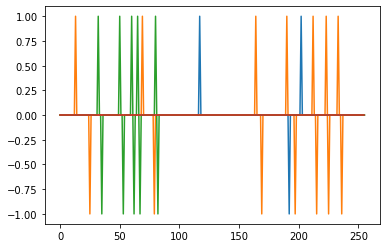

In [30]:
plt.plot(diff[:256, [0, 2, 3, -3]])

In [27]:
data.action_space.sample()

OrderedDict([('attack', array(1)),
             ('back', array(0)),
             ('camera', array([  -6.770445, -115.492714], dtype=float32)),
             ('forward', array(0)),
             ('jump', array(0)),
             ('left', array(1)),
             ('right', array(0)),
             ('sneak', array(0)),
             ('sprint', array(1))])

In [23]:
### add action conditiong to lstm - projecting action and adding to input should be equivalent
### add evaluation
### internal state prediction in n timesteps

In [73]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=10, hidden_size=256, batch_first=True)
        self.out = nn.Linear(256, 10)
        
    def forward(self, x, h0, c0):
        x, (h, c) = self.lstm(x, (h0, c0))
        x = self.out(x)
        disc = torch.sigmoid(x[... , :8])
        cont = torch.tanh(x[... , 8:])
        return disc, cont, h, c

In [74]:
model = Network().cuda()
cont_criterion = nn.MSELoss(reduction='none')
disc_criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [75]:
sum(p.numel() for p in model.parameters())

277002

In [76]:
lstm_size = 256

In [80]:
num_epochs = 1000

for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        loss_masks = torch.unsqueeze(torch.tensor(loss_masks).cuda(), dim=-1)
        actions = torch.tensor(actions).cuda()
        

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        disc, cont, h0, c0 = model(actions, h0, c0)
        
        h0 = h0.detach()
        c0 = c0.detach()
        
        #loss
        loss_disc = disc_criterion(disc[:, :-1, :], actions[:, :-1, :-2]) * loss_masks[:, :-1]
        loss_cont = cont_criterion(cont[:, :-1, :], actions[:, :-1, -2:]) * loss_masks[:, :-1]
        loss = (loss_disc.sum() + loss_cont.sum()) / loss_masks[:, :-1].sum()
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
        
    
    print('')    
    #eval
#     model.eval()
#     loss_sum = 0.
#     loss_denominator = 0.
    
#     batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
#     h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
#     c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
#     for ind in range(gen_len):
#         start = timer()
#         md = get_batch_metadata(batch_master_list, ind)
#         povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
#         povs = torch.tensor(povs).cuda() 
#         loss_masks = torch.tensor(loss_masks).cuda()
#         logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
#         for i, r in enumerate(reset_list):
#             if r:
#                 h0[0, i] = torch.zeros_like(h0[0, i])
#                 c0[0, i] = torch.zeros_like(c0[0, i])
        
#         with torch.no_grad():
#             h0, c0, logits = model(povs, h0, c0)
        
#         loss = double_loss(logits, target, loss_masks)
# #         loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
#         loss_sum += loss.item()
        
#         end = timer()
#         print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
    
#     print('')



C:\Users\mateu\AppData\Local\Temp\ipykernel_23956\1189907476.py:44: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)


Epoch 1 58 / 58 2.3175620683308304 134.41859996318817 0.089068 s
Epoch 2 58 / 58 1.2444421279019322 72.17764341831207 0.027616 ss
Epoch 3 55 / 55 0.8401060797951438 46.20583438873291 0.024986 ss
Epoch 4 66 / 66 0.5355750499575427 35.34795329719782 0.016715 ss
Epoch 5 56 / 56 0.4103650900402239 22.98044504225254 0.045749 sss
Epoch 6 56 / 56 0.28951841353305746 16.21303115785122 0.048882 ss
Epoch 7 54 / 54 0.20609091870762683 11.12890961021185 0.047876 ss
Epoch 8 56 / 56 0.14807293936610222 8.292084604501724 0.049774 ss
Epoch 9 67 / 67 0.09796480573157766 6.563641984015703 0.016467 ss
Epoch 10 58 / 58 0.08374548896119513 4.857238359749317 0.031133 ss
Epoch 11 54 / 54 0.060001061884341414 3.2400573417544365 0.070895 s


KeyboardInterrupt: 

In [79]:
cont_criterion(cont[:, :-1, :], actions[:, :-1, -2:]).shape

torch.Size([32, 255, 2])

In [71]:
disc_criterion(disc[:, :-1, :], actions[:, :-1, :-2]).shape

torch.Size([32, 255, 8])

In [ ]:
from collections import OrderedDict

def obs_transform(obs):
    obs = obs['pov']
    obs = np.expand_dims(obs, 0). astype(np.float32)
    obs = np.transpose(obs, (0, 3, 1, 2)) / 255.
    obs = torch.tensor(obs).cuda()
    return obs

def action_transform(action_discrete, action_camera):
    keys = ['attack', 'back', 'forward', 'jump', 'left', 'right', 'sneak', 'sprint']
    
    action_discrete = action_discrete.cpu().numpy()
    action_discrete = np.ravel(action_discrete)
    action_discrete = np.round(action_discrete)
    
    action_camera = action_camera.cpu().numpy()
    action_camera = np.ravel(action_camera) * 180.
    
    action_dict = {k: np.array(v, dtype=np.int32) for k, v in zip(keys, action_discrete)}
    action_dict['camera'] = action_camera
    
    return OrderedDict(sorted(action_dict.items()))

In [ ]:
# model.eval()

In [ ]:
action_transform(action_discrete, action_camera)

In [ ]:
env.action_space.sample()

In [ ]:
obs = env.reset()

done = False

imgs = [obs['pov']]

while not done:

    with torch.no_grad():
        recon, action_discrete, action_camera = model(obs_transform(obs))
    
    action = action_transform(action_discrete, action_camera)
    obs, reward, done, _ = env.step(action)
    imgs.append(obs['pov'])

In [ ]:
len(imgs)

In [ ]:
plt.imshow(imgs[0])

In [ ]:
import cv2

fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')

video = cv2.VideoWriter('eval.avi', fourcc, 25, (64, 64), isColor=True)

for image in imgs:
    video.write((image).astype(np.uint8)[:, :, ::-1])

cv2.destroyAllWindows()
video.release()